In [1]:
import warnings
warnings.filterwarnings('ignore')

import dill
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

# Preparing the data

## FICO dataset
Dataset: https://community.fico.com/s/explainable-machine-learning-challenge

...

In [2]:
df = pd.read_csv('heloc_dataset_v1.csv')

dataset = df.copy()

In [3]:
data_description = pd.read_excel('heloc_data_dictionary-2.xlsx')
# print(data_description)
# print(dataset.head(10))
# print(dataset.info())
# (dataset.describe())

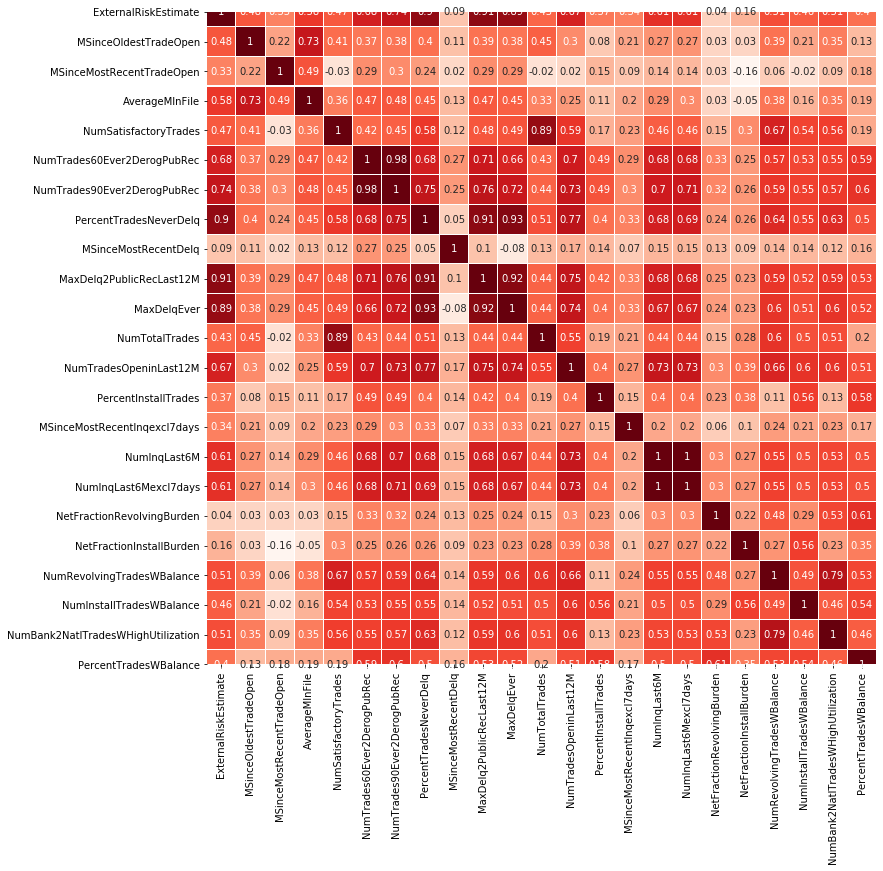

In [4]:
plt.figure(figsize=(12,12))
corr = dataset.corr()
sns.heatmap(round(corr, 2), annot=True, cmap='Reds', linewidths=0.01, cbar=False, );

In [5]:
#Preparing the data

target = 'RiskPerformance'

df = pd.read_csv('heloc_dataset_v1.csv')
fico_y = (df[target] == 'Bad').astype(int)
fico_X = df.drop(target, axis=1)
feature_names = fico_X.columns
feature_names = [feature + ": " + str(idx+1) for idx, feature in enumerate(feature_names)]

print('Percentage of "Bad" target values: ' + str(sum(fico_y)/len(fico_y)))

X_train, X_test, y_train, y_test = train_test_split(fico_X.values, fico_y.values, test_size=0.33, random_state=42)
X_test_smaller = X_test[:150]

X_train_norm = tf.keras.utils.normalize(X_train, axis=1)
X_test_norm = tf.keras.utils.normalize(X_test, axis=1)

Percentage of "Bad" target values: 0.5219428243617936


Data is balanced, accuracy will be used as model evaluation metric.

## Titanic

In [6]:
titanic_train = pd.read_csv('titanic_train.csv')
titanic_test = pd.read_csv('titanic_test.csv')

titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

titanic_train['Age'].fillna(titanic_train['Age'].median(), inplace=True)
titanic_train['Embarked'].fillna('S', inplace=True)

titanic_train['Sex'] = (titanic_train['Sex'] == 'female').astype(int)
titanic_train['Fare'] = titanic_train['Fare'].astype(int)

titanic_train['Embarked'] = titanic_train['Embarked'].map({'Q': 0, 'C': 1, 'S': 2})

titanic_X = titanic_train.drop(['Survived'], axis=1)
titanic_y = titanic_train['Survived']
titanic_X_train, titanic_X_test, titanic_y_train, titanic_y_test = train_test_split(titanic_X, titanic_y, test_size=0.2, random_state=42)

## MNIST

In [7]:
mnist = tf.keras.datasets.mnist
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
mnist_x_train = mnist_x_train/255
mnist_x_test = mnist_x_test/255

<div style='background-color:#e0dab6; padding:20px'>

# Training and evaluating the models  

</div>

In [8]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Linear regression - interpretable model.

In [9]:
# Without normalization


log_model = LogisticRegression(random_state = 42, solver='lbfgs', max_iter = 2000).fit(X_train, y_train)

log_predictions = log_model.predict(X_test)

print(confusion_matrix(y_test, log_predictions))
print(classification_report(y_test, log_predictions))

[[1071  562]
 [ 450 1369]]
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      1633
           1       0.71      0.75      0.73      1819

   micro avg       0.71      0.71      0.71      3452
   macro avg       0.71      0.70      0.70      3452
weighted avg       0.71      0.71      0.71      3452



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [10]:
# With normalization

from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(random_state = 42, solver='lbfgs', max_iter = 2000).fit(X_train_norm, y_train)

log_predictions_norm = log_model.predict(X_test_norm)

print(confusion_matrix(y_test, log_predictions))
print(classification_report(y_test, log_predictions))

[[1071  562]
 [ 450 1369]]
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      1633
           1       0.71      0.75      0.73      1819

   micro avg       0.71      0.71      0.71      3452
   macro avg       0.71      0.70      0.70      3452
weighted avg       0.71      0.71      0.71      3452



## Random forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
# Without normalization

forest_model = RandomForestClassifier(n_estimators = 30, random_state=1).fit(X_train, y_train)
forest_predictions = forest_model.predict(X_test)

print(confusion_matrix(y_test, forest_predictions))
print(classification_report(y_test, forest_predictions))

[[1068  565]
 [ 428 1391]]
              precision    recall  f1-score   support

           0       0.71      0.65      0.68      1633
           1       0.71      0.76      0.74      1819

   micro avg       0.71      0.71      0.71      3452
   macro avg       0.71      0.71      0.71      3452
weighted avg       0.71      0.71      0.71      3452



## XGBoost

### Titanic

In [13]:
import xgboost as xgb

In [14]:
titanic_xgb_model = xgb.XGBClassifier()
titanic_xgb_model.fit(titanic_X_train, titanic_y_train)
xgb_titanic_preds = titanic_xgb_model.predict(titanic_X_test)
xgb_titanic_train_preds = titanic_xgb_model.predict(titanic_X_train)

xgb_titanic_all_preds = titanic_xgb_model.predict(titanic_X)

In [15]:
titanic_xgb_model_2 = xgb.XGBClassifier()
titanic_xgb_model_2.fit(titanic_X_train.as_matrix(), titanic_y_train.as_matrix());

In [16]:
print(classification_report(titanic_y_test, xgb_titanic_preds))
print(accuracy_score(titanic_y_test, xgb_titanic_preds))
print("Training metrics:")
print(classification_report(titanic_y_train, xgb_titanic_train_preds))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       105
           1       0.85      0.72      0.78        74

   micro avg       0.83      0.83      0.83       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

0.8324022346368715
Training metrics:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       444
           1       0.92      0.75      0.83       268

   micro avg       0.88      0.88      0.88       712
   macro avg       0.89      0.86      0.87       712
weighted avg       0.89      0.88      0.88       712



## Neural Network
### Fico

In [17]:
# Without normalization

nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(12, activation=tf.nn.relu, input_shape=X_train.shape[1:]))
nn_model.add(tf.keras.layers.Dense(6, activation=tf.nn.relu, input_shape=X_train.shape[1:]))
nn_model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

nn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']);

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [18]:
nn_model.fit(X_train, y_train, batch_size=32, epochs=15);

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
7007/7007 [==============================] - 2s 248us/sample - loss: 7.8906 - acc: 0.4887
Epoch 2/15
7007/7007 [==============================] - 1s 94us/sample - loss: 3.1189 - acc: 0.5854
Epoch 3/15
7007/7007 [==============================] - 1s 95us/sample - loss: 0.5997 - acc: 0.6766
Epoch 4/15
7007/7007 [==============================] - 1s 99us/sample - loss: 0.5940 - acc: 0.6895
Epoch 5/15
7007/7007 [==============================] - 1s 96us/sample - loss: 0.5857 - acc: 0.6940
Epoch 6/15
7007/7007 [==============================] - 1s 116us/sample - loss: 0.5915 - acc: 0.6959
Epoch 7/15
7007/7007 [==============================] - 1s 109us/sample - loss: 0.5855 - acc: 0.6959
Epoch 8/15
7007/7007 [==============================] - 1s 110us/sample - loss: 0.5788 - acc: 0.7064
Epoch 9/15
7007/7007 [==============================] - 1s 100us/sample - loss: 0.5823 - acc: 0.7009
Epoch 10/15
7007/7007 [========================

In [19]:
nn_loss, nn_acc = nn_model.evaluate(X_test, y_test)
print('Loss: ' + str(nn_loss))
print(nn_acc)

#PREDICTIONS - probability of bad risk performance

nn_predictions = nn_model.predict(X_test)
nn_predictions = [1 if pred >= 0.5 else 0 for pred in nn_predictions]

nn_matches = [1 if i == j else 0 for i, j in zip(nn_predictions, y_test)] # Matches calculated for later usage
nn_accuracy = sum(nn_matches)/len(nn_matches)
print('Accuracy: ' + str(nn_accuracy))

3452/3452 [==============================] - 0s 105us/sample - loss: 0.5867 - acc: 0.6918
Loss: 0.5867182711875314
0.6917729
Accuracy: 0.6917728852838934


In [20]:
# With normalization

nn_model_norm = tf.keras.models.Sequential()
nn_model_norm.add(tf.keras.layers.Dense(12, activation=tf.nn.relu, input_shape=X_train.shape[1:]))
nn_model_norm.add(tf.keras.layers.Dense(6, activation=tf.nn.relu, input_shape=X_train.shape[1:]))
nn_model_norm.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

nn_model_norm.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']);

In [21]:
nn_model_norm.fit(X_train_norm, y_train, batch_size=32, epochs=15);

Epoch 1/15
7007/7007 [==============================] - 2s 251us/sample - loss: 0.6884 - acc: 0.5906
Epoch 2/15
7007/7007 [==============================] - 1s 98us/sample - loss: 0.6564 - acc: 0.6749
Epoch 3/15
7007/7007 [==============================] - 1s 99us/sample - loss: 0.6130 - acc: 0.6780
Epoch 4/15
7007/7007 [==============================] - 1s 95us/sample - loss: 0.5980 - acc: 0.6885
Epoch 5/15
7007/7007 [==============================] - 1s 95us/sample - loss: 0.5923 - acc: 0.6952
Epoch 6/15
7007/7007 [==============================] - 1s 94us/sample - loss: 0.5895 - acc: 0.6942
Epoch 7/15
7007/7007 [==============================] - 1s 98us/sample - loss: 0.5876 - acc: 0.6950
Epoch 8/15
7007/7007 [==============================] - 1s 97us/sample - loss: 0.5859 - acc: 0.6973
Epoch 9/15
7007/7007 [==============================] - 1s 97us/sample - loss: 0.5858 - acc: 0.6974
Epoch 10/15
7007/7007 [==============================] - 1s 96us/sample - loss: 0.5846 - acc: 0.698

In [22]:
nn_loss_norm, nn_acc_norm = nn_model_norm.evaluate(X_test_norm, y_test)
print('Loss: ' + str(nn_loss_norm))
print(nn_acc_norm)

#PREDICTIONS - probability of bad risk performance

nn_predictions_percent_norm = nn_model_norm.predict(X_test_norm)
nn_predictions_norm = [1 if pred >= 0.5 else 0 for pred in nn_predictions_percent_norm]

nn_matches_norm = [1 if i == j else 0 for i, j in zip(nn_predictions_norm, y_test)] # Matches calculated for later usage
nn_accuracy_norm = sum(nn_matches_norm)/len(nn_matches_norm)
print('Accuracy: ' + str(nn_accuracy_norm))

3452/3452 [==============================] - 0s 108us/sample - loss: 0.5972 - acc: 0.6825
Loss: 0.5972353610213358
0.6825029
Accuracy: 0.6825028968713789


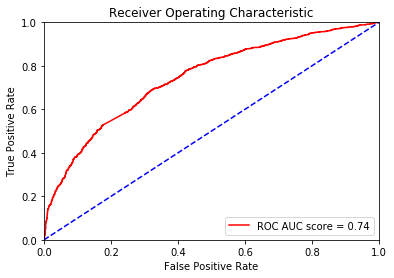

In [23]:
preds = nn_predictions_percent_norm[:]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Neural network
### MNIST

In [24]:
mnist_nn_model = tf.keras.models.Sequential()
mnist_nn_model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
mnist_nn_model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
mnist_nn_model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

mnist_nn_model.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mnist_nn_model.fit(mnist_x_train, mnist_y_train)

60000/60000 [==============================] - 18s 306us/sample - loss: 0.2596 - acc: 0.9266


In [25]:
mnist_nn_loss, mnist_nn_accuracy = mnist_nn_model.evaluate(mnist_x_test, mnist_y_test)

10000/10000 [==============================] - 1s 100us/sample - loss: 0.1354 - acc: 0.9583


<div style='background-color:#42b3f5; padding:20px'>
    
# Explaining models decisions

</div>

In [26]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from pdpbox import pdp, get_dataset, info_plots
import shap
import lime

shap.initjs()

<div style='background-color:#b6e0ba; padding:20px'>

# Interpretable model

</div>

## Logistic regression

Feature weights are shown below. However they are not the best method to analyze regression model, unless feature values are normalized. Because feature values can have different ranges, feature effect is more informative - feature weight times feature value, which can be evaluated for a specific observation.

In [27]:
log_reg_df = pd.DataFrame()

log_reg_df['Feature'] = feature_names
log_reg_df['Weight'] = log_model.coef_[0]

# feature_effects = []
# for col, weight in zip(fico_X, log_model.coef_[0]):
#     feature_effects.append(weight * fico_X[col].mean())
# log_reg_df['Effect'] = feature_effects
    
log_reg_df['AbsWeight'] = log_reg_df['Weight'].apply(lambda x: abs(x))
log_reg_df.sort_values(by='AbsWeight', inplace=True, ascending=False)
log_reg_df.drop('AbsWeight', axis=1, inplace=True)
    
log_reg_df.style.background_gradient(cmap='magma', subset=['Weight']).highlight_max(subset=['Weight']).set_caption('Comparison of weight and feature effect.')

,Feature,Weight
17,NetFractionRevolvingBurden: 18,4.2631
0,ExternalRiskEstimate: 1,-3.39308
14,MSinceMostRecentInqexcl7days: 15,-3.37974
22,PercentTradesWBalance: 23,2.71858
13,PercentInstallTrades: 14,2.34557
15,NumInqLast6M: 16,2.29617
16,NumInqLast6Mexcl7days: 17,2.12879
3,AverageMInFile: 4,-2.07044
9,MaxDelq2PublicRecLast12M: 10,-1.87248
4,NumSatisfactoryTrades: 5,-1.8172


<div style='background-color:#b6e0ba; padding:20px'>

# Permutation importance

</div>

Works by permutating values of a feature in the dataset and measuring change in error. High error means the feature is important. If features are correlated, unrealistic observations may be created.

In [28]:
perm = PermutationImportance(forest_model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.0384 ± 0.0068,ExternalRiskEstimate: 1
0.0239 ± 0.0073,AverageMInFile: 4
0.0203 ± 0.0104,NetFractionRevolvingBurden: 18
0.0190 ± 0.0041,MSinceMostRecentInqexcl7days: 15
0.0183 ± 0.0061,PercentTradesNeverDelq: 8
0.0133 ± 0.0048,PercentTradesWBalance: 23
0.0122 ± 0.0070,MSinceOldestTradeOpen: 2
0.0111 ± 0.0044,MSinceMostRecentDelq: 9
0.0110 ± 0.0034,NumSatisfactoryTrades: 5
0.0083 ± 0.0028,MaxDelqEver: 11


<div style='background-color:#b6e0ba; padding:20px'>

# Local surrogate (LIME)

</div>

Creating local explanation by generating data around observations and fitting interpretable model around them.  Explanation of observation x can be found by solving:
\begin{equation*}
explanation(x)=arg\ \min_{g \in G} L(f,g,\pi _{x})+\Omega(g)
\end{equation*}
Where g is an interpretable model that minimizes L, function that tells how close the interpretable model prediction is to the complex model prediction. $\Omega$ is a function measuring complexity, and $\pi_x$ is called proximity measure and defines how large a distance is considered to be a neighbourhood of the observation and should be used in creating explanation. Exponential smoothing kernel is a function LIME uses to measure distance between two data points, and kernel width is it's parameter affecting how far the observations have to be to be considered neighbors. Right kernel width is crucial for LIME to find the right explanation. 

Lime can be used to explain tabular data, text or images. For tabular data, points of which the neighbourhood is chosen are generated based on mean and standard deviation of original data, therefore access to the training data is necessary for LIME. These statistics are also used to account for difference of ranges between the features, allowing to fairly compute distance (LIME documentation).

In [29]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=titanic_X.values, feature_names=titanic_X.columns)
i = np.random.randint(0, titanic_X.shape[0])
exp = explainer.explain_instance(titanic_X.values[i], titanic_xgb_model_2.predict_proba, num_features=5, top_labels=1)
print(titanic_y.values[i])

1


In [30]:
exp.show_in_notebook(show_table=True, show_all=False)

LIME for images - superpixels

10000/10000 [==============================] - 6s 568us/sample - loss: 0.3983 - acc: 0.8834


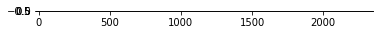

In [31]:
from skimage.color import gray2rgb
rgb_images = [gray2rgb(img).reshape(1,-1) for img in mnist_x_test]

exp_img = rgb_images[4]
plt.imshow(exp_img)

lime_nn_model = tf.keras.models.Sequential()
lime_nn_model.add(tf.keras.layers.Flatten())
lime_nn_model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
lime_nn_model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

lime_nn_model.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lime_nn_model.fit(np.array(rgb_images), mnist_y_test)

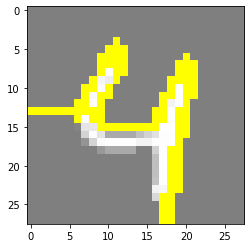

In [32]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(rgb_images[4].reshape(28,28,3), lime_nn_model.predict, top_labels=10, num_samples=50)

temp, mask = explanation.get_image_and_mask(mnist_y_test[4], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<div style='background-color:#b6e0ba; padding:20px'>
    
# Global surrogate

</div>

Fitting an interpretable model that predicts more complicated model output, instead of the real output class. Simpler model aims to replicate the latter and make interpretation possible.

### XGBoost with decision tree

In [33]:
tree_titanic_xgb_surrogate = DecisionTreeClassifier(max_depth=2)
tree_titanic_xgb_surrogate.fit(titanic_X, xgb_titanic_all_preds)

tree_xgb_surrogate_preds = tree_titanic_xgb_surrogate.predict(titanic_X)

[[524  86]
 [ 16 265]]
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       610
           1       0.75      0.94      0.84       281

   micro avg       0.89      0.89      0.89       891
   macro avg       0.86      0.90      0.87       891
weighted avg       0.90      0.89      0.89       891



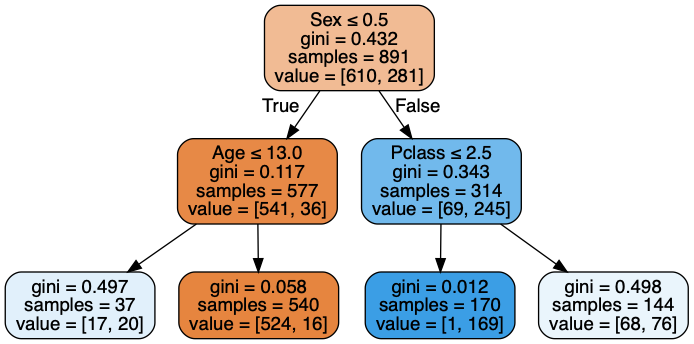

In [34]:
print(confusion_matrix(xgb_titanic_all_preds, tree_xgb_surrogate_preds))
print(classification_report(xgb_titanic_all_preds, tree_xgb_surrogate_preds))

dot_data = StringIO()
export_graphviz(tree_titanic_xgb_surrogate, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=titanic_X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Evaluating decision tree performance on titanic set:

In [124]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(titanic_X, titanic_y)

tp = tree.predict(titanic_X)

[[532  17]
 [165 177]]
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       549
           1       0.91      0.52      0.66       342

   micro avg       0.80      0.80      0.80       891
   macro avg       0.84      0.74      0.76       891
weighted avg       0.82      0.80      0.78       891



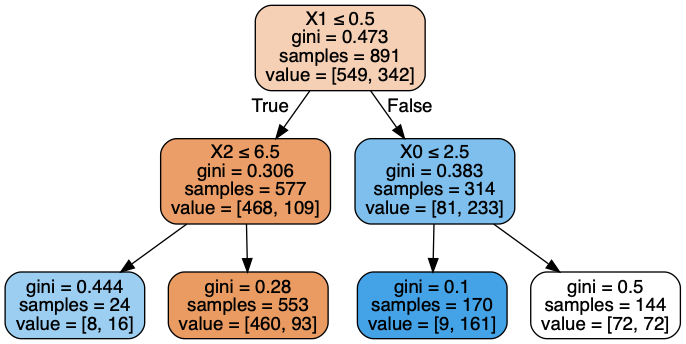

In [125]:
print(confusion_matrix(titanic_y, tp))
print(classification_report(titanic_y, tp))

dot_data2 = StringIO()
export_graphviz(tree, out_file=dot_data2,  
                filled=True, rounded=True,
                special_characters=True)

graph2 = pydotplus.graph_from_dot_data(dot_data2.getvalue())  
Image(graph2.create_png())

## TODO - find a model where surrogate of a complex model is significantly better at predicting complex model output than simple model is at predicting real data.

<div style='background-color:#b6e0ba; padding:20px'>

# Partial dependence plots / Individual Conditional Expectation (PDP/ICE), ALE

</div>

PDP visualizes marginal effect of a given feature denoted S by plotting average model outcome for different values of the predictor, denoted C. 

\begin{equation*}
f_{x_S}=E_{x_C}[f(x_S,x_C)]=\int f(x_S,x_C) dP(x_C)
\end{equation*}

To substitute for integration over every value, the formula is estimated by:

\begin{equation*}
\hat{f_{x_S}}=\frac{1}{N}\sum_{i=1} \hat{f}(x_S,x_{C_i})
\end{equation*}

Where x_s is the value of a chosen feature for which we'd like to get marginal effect on the output, N is number of all the observations and x_c are the values of every other feature of all the other observations. By repeating this process for all the x_s we get a line of average contributions of the chosen feature, called PDP. In other words, we see average output if we plug x_s value to every observation.

Assumption is that features in x_s and x_c are not correlated. If the correlation exists, we would examine unprobable or impossible observations.

ALE (Accumulated Local Effects) can be used to find second-order effects.

## Univariate Partial Dependence Plots

In [126]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False, rug=False):
    plt.figure(figsize=(2,1))
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag, show_percentile=True)
    if rug:
        sns.distplot(df[feature], hist=False, kde=False, 
                     rug=True)
    plt.show()

### Forest model

<Figure size 144x72 with 0 Axes>

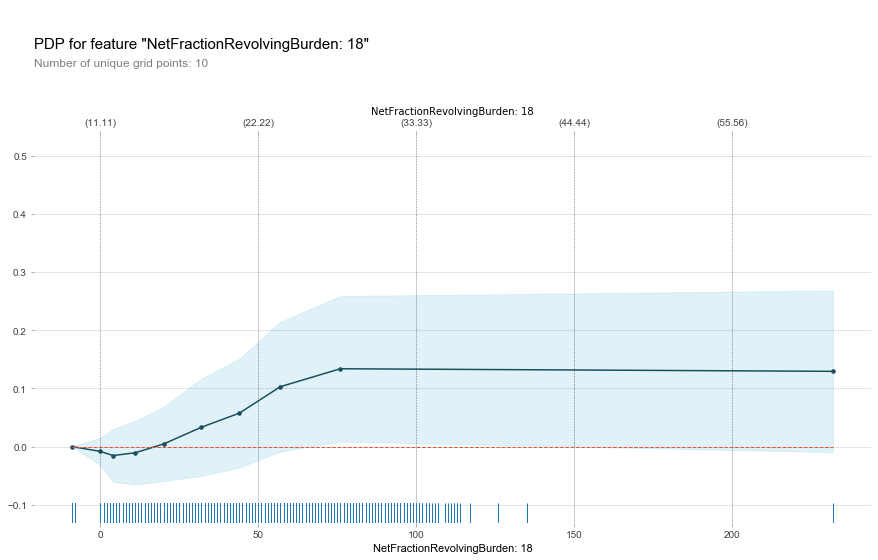

In [127]:
plot_pdp(forest_model, pd.DataFrame(X_test, columns=feature_names), feature_names[17], rug=True)

### Artificial neural network

<Figure size 144x72 with 0 Axes>

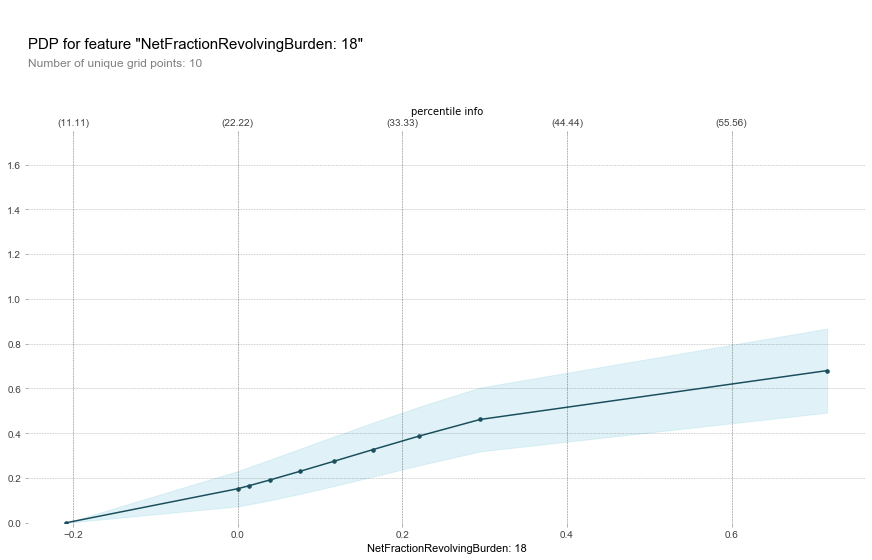

In [128]:
plot_pdp(nn_model_norm, pd.DataFrame(X_test_norm, columns=feature_names), feature_names[17])

## Univariate ICE plot

<Figure size 144x72 with 0 Axes>

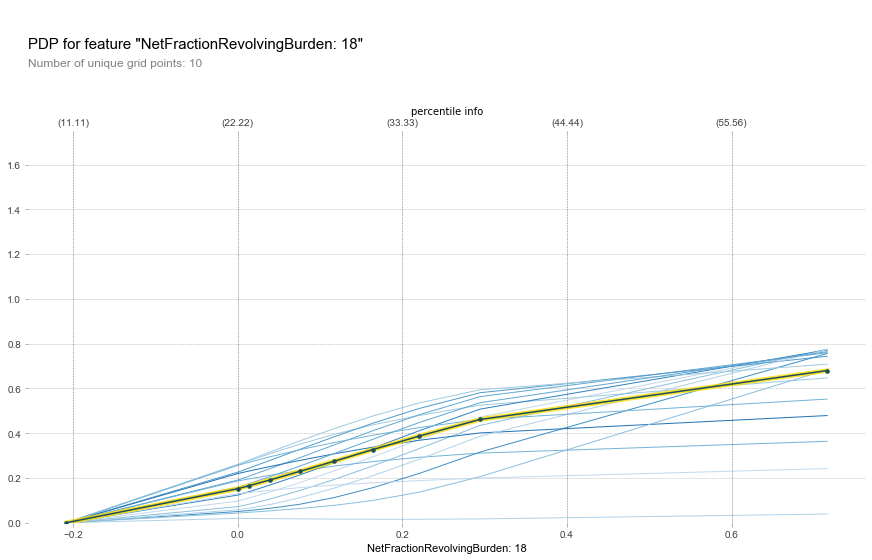

In [129]:
plot_pdp(nn_model_norm, pd.DataFrame(X_test_norm, columns=feature_names), feature_names[17], cluster_flag=True, nb_clusters=16, lines_flag=True)

## Bivariate partial dependence plot

### NN - FICO

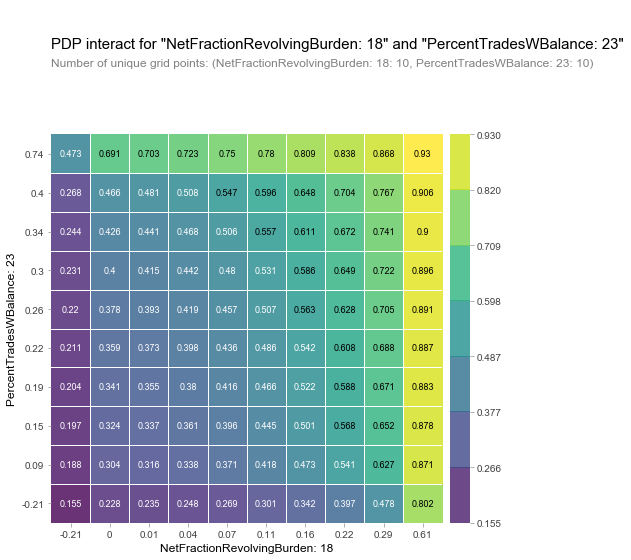

In [130]:
features_to_plot = [feature_names[17], feature_names[22]]
inter1  =  pdp.pdp_interact(model=nn_model_norm, dataset=pd.DataFrame(X_train_norm, columns=feature_names), model_features=feature_names, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')

plt.show()

### XGB - Titanic

In [131]:
titanic_X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

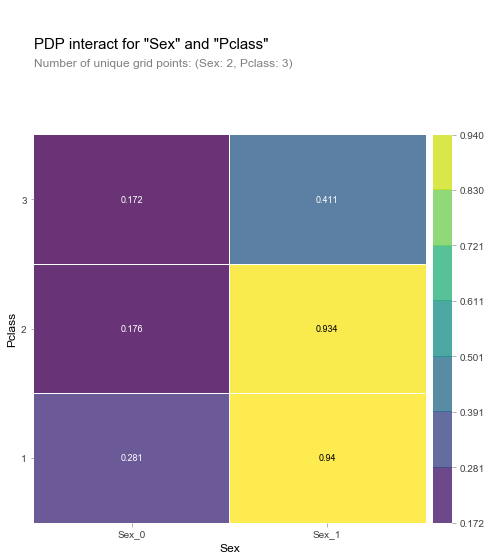

In [132]:
features_to_plot = ['Sex', 'Pclass']
inter1  =  pdp.pdp_interact(model=titanic_xgb_model, dataset=titanic_X, model_features=titanic_X.columns, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')

plt.show()

<div style='background-color:#b6e0ba; padding:20px'>

# SHAP

</div>


Using game theory - treating features as players and calculating their contribution. This allows as to interpret the model globally in some sense by looking at many predictions at once or locally by looking at shapley values for single prediction. Below, is denoted a modified for machine learning equation for computing contribution of players in a game. It calculates shapley values for a single feature <em>i</em> in single a observation:

\begin{equation*}
\phi_i(f,x)=\sum_{z' \subseteq x'} \frac{|z'|!(M-|z'|-1)!}{M!}[f_x(z')-f_x(z'\setminus i)]
\end{equation*}

F is the model, x is the observation to be explained. M denotes the number of features, z' is a vector where some subset of explained instance is present. For feature to be missing is to substitute its value with expected expected value of the feature across the entire dataset. First part of the sum calculates how many of all possible feature permutation current summation step describes. |z'| denotes the number of features we have present - similar to the player contribution equation, nominator counts the all the possibilites of how all the other players (here features) could have come before and after currently evaluated player for given subset of players. By dividing it by all possible feature permutation, we get it's weight. The final subtraction is the marginal effect of currently evaluated evaluated feature.  
Source - (3)



#### SHAP - TreeExplainer

In TreeSHAP paper (4) method to compute shap values for tree ensembles was proposed. It reduces computional complexity from <i> O(TL2<sup>M</sup>) </i> to <i> O(TLD<sup>2</sup>)</i>

#### SHAP - DeepExplainer

For deep learning models, shapley values are approximated with help of DeepLIFT alghoritm.

## SHAP summary plot

Plots shapley values and values of all features for every observation passed to the function in one plot.

### DeepExplainer - Artificial neural network - FICO

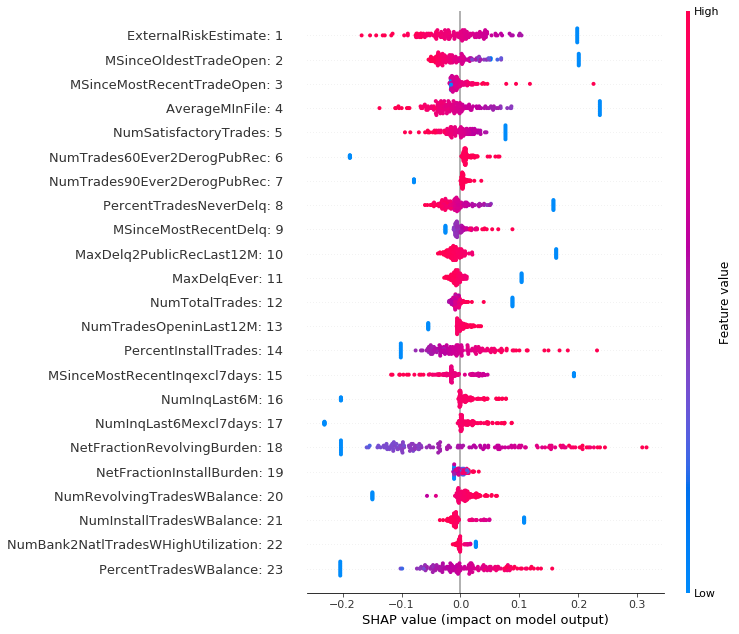

In [133]:
# With normalization

X_test_norm_smaller = X_test_norm[:150]

nn_norm_explainer = shap.DeepExplainer(nn_model_norm, X_test_norm_smaller)
nn_norm_shap_values = nn_norm_explainer.shap_values(X_test_norm_smaller)
shap.summary_plot(nn_norm_shap_values[0], X_test_norm_smaller, feature_names=feature_names, sort=False, max_display=23)

### DeepExplainer - NN - MNIST

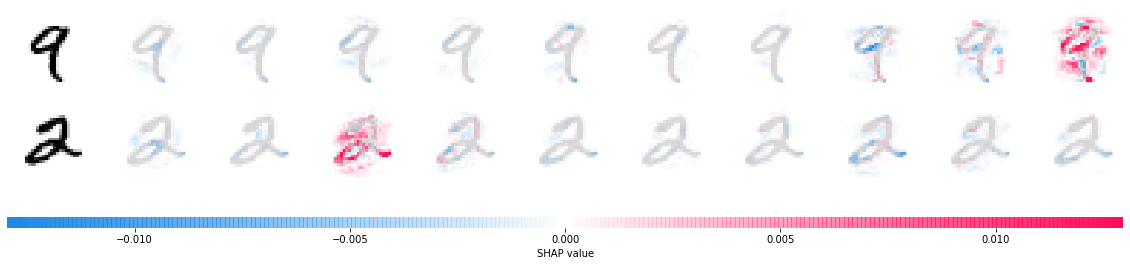

In [134]:
background = mnist_x_train[np.random.permutation(len(mnist_x_train))[:100]]

mnist_img_explaner = shap.DeepExplainer(mnist_nn_model, background)

mnist_shap_vals = mnist_img_explaner.shap_values(mnist_x_train[4:6])

shap.image_plot(mnist_shap_vals, -mnist_x_train[4:6])

### TreeExplainer - XGBoost - Titanic

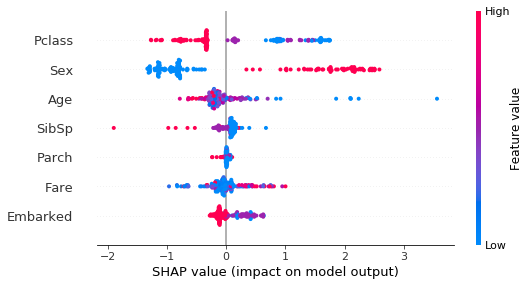

In [135]:
xgb_explainer = shap.TreeExplainer(titanic_xgb_model)
xgb_shap_values = xgb_explainer.shap_values(titanic_X_test)
shap.summary_plot(xgb_shap_values, titanic_X_test, feature_names=titanic_X_test.columns, sort=False, max_display=23)

## SHAP Force plot

Plots every passed observation and groups simillar instances.

### Nueral network - FICO

In [136]:
shap.force_plot(nn_norm_explainer.expected_value, nn_norm_shap_values[0], X_test_norm_smaller)

In [137]:
shap.force_plot(nn_norm_explainer.expected_value, xgb_shap_values, titanic_X_test)

## SHAP Feature importance

Average of every shapley value across the data for a feature.

### Neural network - FICO

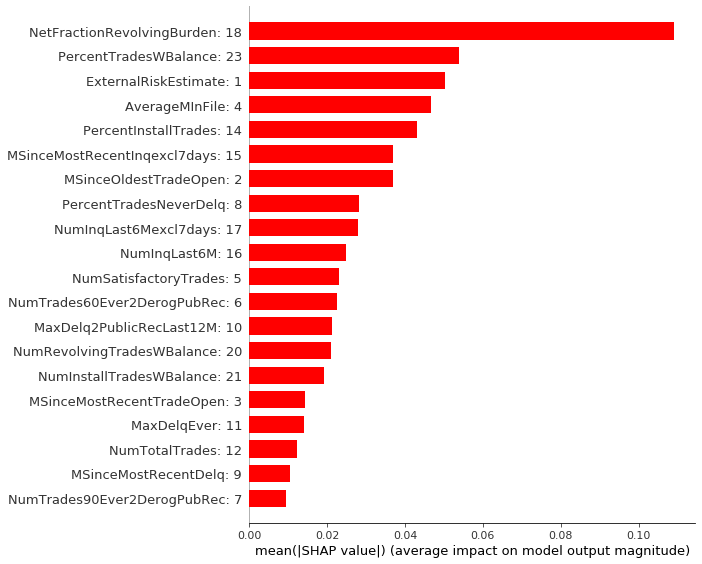

In [138]:
shap.summary_plot(nn_norm_shap_values[0], X_test_norm_smaller, plot_type="bar", color='red', feature_names=feature_names)

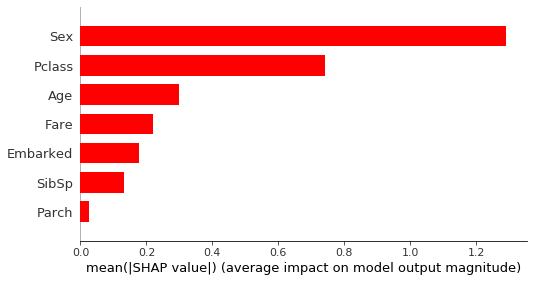

In [139]:
shap.summary_plot(xgb_shap_values, titanic_X_test, plot_type="bar", color='red', feature_names=titanic_X.columns)

### SHAP Dependence/interaction plot

Shapley interaction values:
\begin{equation*}
\phi_{i,j}(f,x)=\sum_{S \subseteq \{i,j\}} \frac{|S|!(M-|S|-2)!}{2(M-1)!}\delta_{i,j}(S)
\end{equation*}
\begin{equation*}
(i \neq j)
\end{equation*}
\begin{equation*}
\delta_{i,j}(S)=f_x(S \cup \{i,j\})-f_x(S\cup \{i\})-f_x(S\cup{j})+f_x(S)
\end{equation*}

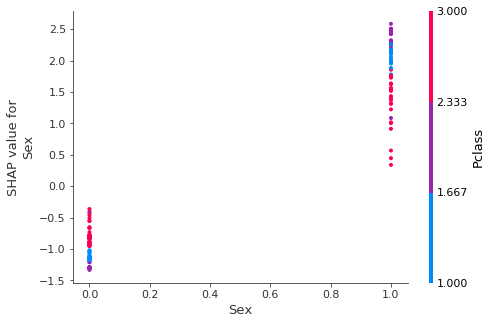

In [140]:
shap.dependence_plot(1, xgb_shap_values, titanic_X_test)

<div style='background-color:#bceaf5; padding:20px'>
    
# Explaining inidividual predictions

</div>

## Conterfactual example
In (9) suggested way of explainig single observation is finding a conterfactual example $ x' $ that explains observation $ x $ by minimising:
$$ L(x, x', y', \lambda)= \lambda(\hat{f}(x')-y')^2 + d(x,x')$$
$ y' $ is desired outcome defined by the user, different than outcome of example to be explained. $ d $ is the distance function, for example eclidean distance.

## Adversarial Examples
Adversarial examples are created by slightly preturbing original observation to achieve different output, simillary to the conterfactual example.

In [141]:
# Observation with a bad risk performed will be evaluated and modified to change model's decision
shap.force_plot(nn_norm_explainer.expected_value, nn_norm_shap_values[0][31], feature_names=feature_names)

The model predicted the right outcome for observation 31, however it was not sure with 56% certainty.
Tweaking the most important features a little should change the model prediction. 
Analyzing the summary plot of the model gives an idea of how should we change them.
If the person would like to have a good risk performance, the best bet
would be to increase his Average Months in File (feature 4) and decreasing Percent Trades with Balance (feature 23).

In [142]:
mod_x = X_test_norm[31].copy()
mod_x[3] = mod_x[3]*1.1
mod_x[22] = mod_x[22]*0.9

mod_shap_vals = nn_norm_explainer.shap_values(np.asarray([mod_x]))
shap.force_plot(nn_norm_explainer.expected_value, mod_shap_vals[0][0], feature_names=feature_names)

Slight change in the features resulted in a different prediction.

In [143]:
#Finding a good match


# print(y_test[9])
print([(i, y_test[i])for i, x in enumerate(nn_matches_norm) if x == 1 and y_test[i] == 1 and nn_predictions_percent_norm[i] < 0.55])


[(31, 1), (36, 1), (75, 1), (78, 1), (89, 1), (203, 1), (205, 1), (247, 1), (248, 1), (283, 1), (337, 1), (342, 1), (412, 1), (502, 1), (569, 1), (658, 1), (663, 1), (702, 1), (720, 1), (733, 1), (737, 1), (776, 1), (786, 1), (835, 1), (902, 1), (1047, 1), (1111, 1), (1116, 1), (1132, 1), (1340, 1), (1347, 1), (1417, 1), (1423, 1), (1430, 1), (1436, 1), (1450, 1), (1493, 1), (1503, 1), (1547, 1), (1595, 1), (1618, 1), (1636, 1), (1666, 1), (1688, 1), (1694, 1), (1698, 1), (1762, 1), (1763, 1), (1776, 1), (1868, 1), (1871, 1), (1890, 1), (1904, 1), (1907, 1), (2022, 1), (2065, 1), (2069, 1), (2136, 1), (2155, 1), (2182, 1), (2192, 1), (2197, 1), (2218, 1), (2239, 1), (2250, 1), (2259, 1), (2294, 1), (2330, 1), (2338, 1), (2350, 1), (2354, 1), (2375, 1), (2385, 1), (2394, 1), (2460, 1), (2499, 1), (2513, 1), (2521, 1), (2562, 1), (2603, 1), (2610, 1), (2640, 1), (2679, 1), (2695, 1), (2705, 1), (2750, 1), (2756, 1), (2857, 1), (2871, 1), (2900, 1), (2941, 1), (2944, 1), (2985, 1), (2995,

<div style='background-color:#e7ffdb; padding:20px'>
    
# Rough summary

Neural network with normalization learned linear, monotonic dependecies, given in the data description file; probably no non-linear connections between features are present.

Publications/books:  
(1) XGBoost paper: https://arxiv.org/pdf/1603.02754.pdf  
(2) Lime paper: https://arxiv.org/abs/1602.04938  
(3) Shap paper: https://arxiv.org/abs/1705.07874  
(4) TreeShap extension paper (shap optimised for tree ensembles): https://arxiv.org/abs/1802.03888  
(5) DeepLIFT: https://arxiv.org/abs/1704.02685  
ICE/PDP paper: https://arxiv.org/abs/1309.6392  
Arguments against explainability of black box models: https://arxiv.org/abs/1811.10154  
Interpretability book: https://christophm.github.io/interpretable-ml-book/  
(9) Conterfactual examples (example based explanations): https://arxiv.org/abs/1711.00399  
Global surrogate with tree, TREPAN:  
https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf  
https://www.biostat.wisc.edu/~craven/papers/thesis.pdf (expanded)  
Permutation importance: https://arxiv.org/pdf/1801.01489.pdf  
Stability/robustness of interpretation methods: https://arxiv.org/abs/1806.08049  

Tutorials/articles:  
Fico dataset challange winner's solution: https://community.fico.com/s/blog-post/a5Q2E0000001czyUAA/fico1670  


Tutorials:  
https://github.com/cog-data/ML_Interpretability_tutorial/blob/master/Machine_Learning_Interpretability_tutorial.ipynb 
http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html  
https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d 
https://towardsdatascience.com/interpreting-your-deep-learning-model-by-shap-e69be2b47893
https://www.kaggle.com/learn/machine-learning-explainability
https://towardsdatascience.com/explainable-artificial-intelligence-part-2-model-interpretation-strategies-75d4afa6b739

Lime documentation: https://github.com/marcotcr/lime  
SKATER: https://www.oreilly.com/ideas/interpreting-predictive-models-with-skater-unboxing-model-opacity  
Metrics comparison:  https://towardsdatascience.com/choosing-the-right-metric-is-a-huge-issue-99ccbe73de61 


Multicollinearity in regression:  
https://arxiv.org/pdf/1902.03272.pdf  
https://damariszurell.github.io/files/Dormann_etal_Ecography_2013.pdf  